In [91]:
import acoular as ac
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as anim
from matplotlib.colors import LinearSegmentedColormap
#conda install -c conda-forge ffmpeg   


In [92]:
############################################
# camera parameters
cameraPosition = 2

# don't be a fool, count like a computer
camPos = int(cameraPosition - 1)

# Camera Angles
azimuth =  np.array([-133.33136452241695,164.2465834869733+15])[camPos]
elevation = np.array([-27.020027669675454,64.11592446841624-10])[camPos]

ax_xlim = [[1.4, 0.2], [1.4, 0.2]][camPos]
ax_ylim = [[0, 1.4], [0, 1.4]][camPos]
ax_zlim = [[0, 2], [0, 2]][camPos]

#colorbar position
fraction = [0, 0.03][camPos]
pad = [0, -0.2][camPos]


############################################
# plot parameters

dotsize = 4* 10**-3
size_exponent = 3

#dotsize = 10**-6
#size_exponent = 5

# Set dynamic range
vmin = 60
vmax = 90

number_of_points_per_frame = 10

width_pixels = 1440
height_pixels = 1920
dpi = 80

plot_bassoon = [True, False][0]

############################################
# data parameters

dataName = '2025-01-28_15-01-02_954236'

resFolderName = 'out/beamforming_results_25_02_16/'+dataName
resFileName = 'out/video_data/'+ dataName + '_camera_' + str(cameraPosition) + '.mov'

currentFrequencyBand = 3
currentFrame = 60

In [93]:
# Open and read the JSON file
with open(resFolderName + '/evaluation_config.json', 'r') as file:
    config_data = json.load(file)

# Access the output folder path
out_folder = config_data['out_folder']
print(f"Output Folder: {out_folder}")

# read Data
result = np.load(resFolderName+ '/result_'+dataName + ".npy")
map = ac.fbeamform.L_p(result) # p0 = 4 * 10**-4

resolution = config_data['calc_grid_res_meters']
frequencyBands = config_data['frequency_bands']

maxValue = np.max(map)
print("global max:", maxValue)
print(map.shape)

Output Folder: ./evaluation/out/
global max: 87.0281329700549
(5, 772, 25, 25, 36)


In [94]:
# get indices of 50 highest values
map_flat = map[currentFrequencyBand, currentFrame].flatten()
top_indices = np.argpartition(map_flat, -number_of_points_per_frame)[-number_of_points_per_frame:]


# get x, y, z values
x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[2]*resolution,map.shape[2]),
                            np.linspace(0,map.shape[3]*resolution,map.shape[3]), 
                            np.linspace(0,map.shape[4]*resolution,map.shape[4]))

x_m_flat = x_m.flatten()
y_m_flat = y_m.flatten()
z_m_flat = z_m.flatten()


# Filter the points above the threshold
above_threshold = map_flat > vmin
x_m_thresh = x_m_flat[above_threshold]
y_m_thresh = y_m_flat[above_threshold]
z_m_thresh = z_m_flat[above_threshold]
values_thresh = map_flat[above_threshold]

size = (values_thresh)**size_exponent * dotsize

print("Points per frame: ", + len(values_thresh))

Points per frame:  4


sound pressure distribution in 1000 Hz octave band


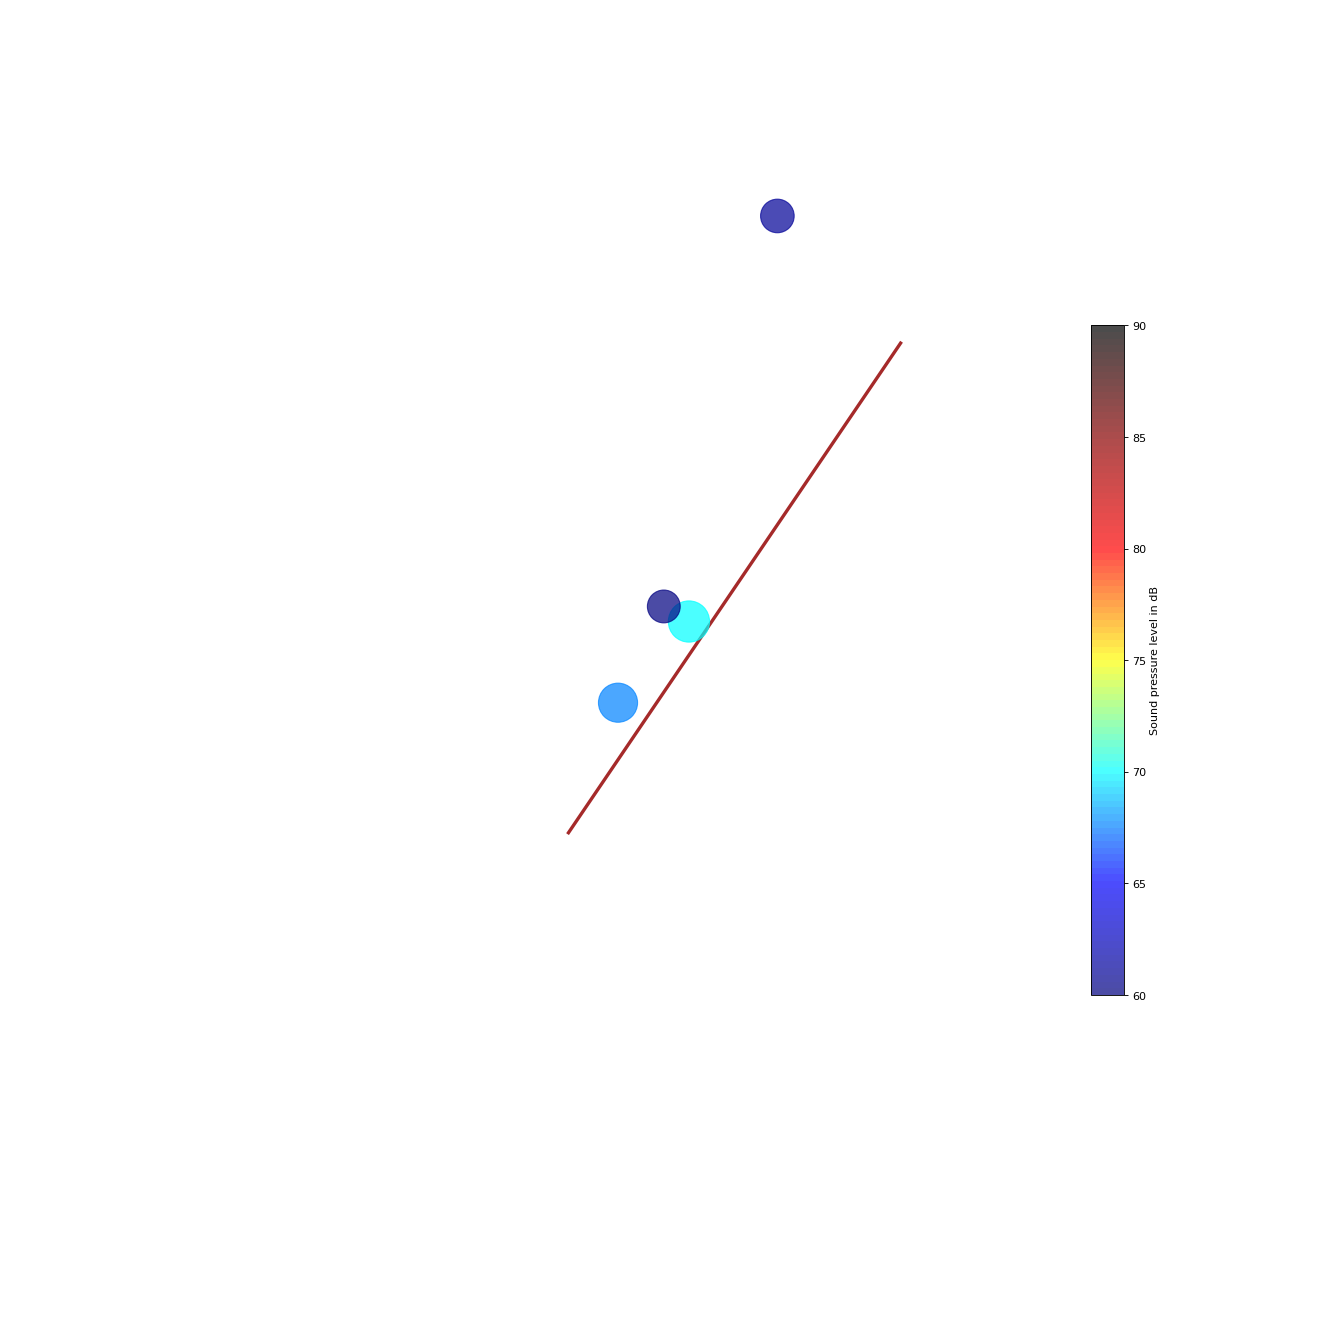

In [95]:
# Calculate figsize in inches (pixels / dpi)
figsize = (width_pixels / dpi, height_pixels / dpi)

# init figure
fig = plt.figure(figsize = figsize, dpi=dpi)

# camera perspective
ax = fig.add_subplot(projection='3d')
ax.set_proj_type('persp', focal_length=0.1)#0.547)
ax.view_init(elev=elevation, azim=azimuth, roll=0)

# plot bassoon line:
if plot_bassoon == True:
    bassoon_low_xyz = [0.97081132, 0.98296962, 0.41316809]
    bassoon_high_xyz = [0.53056959, 0.3204048, 1.48546785]
    x_line = [bassoon_low_xyz[0], bassoon_high_xyz[0]]
    y_line = [bassoon_low_xyz[1], bassoon_high_xyz[1]]
    z_line = [bassoon_low_xyz[2], bassoon_high_xyz[2]]
    ax.plot(x_line, y_line, z_line, linewidth=3, color='brown')
    #ax.scatter(bassoon_low_xyz, bassoon_high_xyz, s=100, color='brown')


# plot Beamforming data
colors = ["navy", "blue", "cyan", "yellow", "red", "darkred", "black"]
custom_cmap = LinearSegmentedColormap.from_list("custom", colors, N=100)

scat = ax.scatter(x_m_thresh, y_m_thresh, z_m_thresh,
                  c=values_thresh,
                  cmap=custom_cmap,
                  alpha=0.7,
                  s=size,
                  vmin=vmin,
                  vmax = vmax)

# plot title (leave out for more space on fig)
#ax.set_title('sound pressure distribution in \n '+str(frequencyBands[currentFrequencyBand])+' Hz octave Band')
print('sound pressure distribution in '+str(frequencyBands[currentFrequencyBand])+' Hz octave band')

# correct grid
ax.set_xlim(ax_xlim)
ax.set_ylim(ax_ylim)
ax.set_zlim(ax_zlim)
ax.set_aspect('equal')

# remove background and axis
fig.patch.set_facecolor('none')
ax.set_axis_off()
ax.set_facecolor('none')

# Add colorbar
cbar = plt.colorbar(scat, ax=ax, fraction=fraction, pad=pad)
cbar.set_label('Sound pressure level in dB')

# update function also works with global variables
def update(frame):
    
    # Extract values for this specific frame
    values = map[currentFrequencyBand, frame, :, :, :].flatten()
    
    # Apply a threshold to filter the data
    mask = values > vmin  # Define a threshold for visibility
    filtered_values = values[mask]
    
    # Get the coordinates for these filtered values
    x_filtered = x_m.flatten()[mask]
    y_filtered = y_m.flatten()[mask]
    z_filtered = z_m.flatten()[mask]
    
    # Update color, size, alpha
    color = filtered_values  # Can apply normalization or scaling
    size = (filtered_values ** size_exponent) * dotsize  # Adjust size based on values
        
    # Update the scatter plot with new values
    scat._offsets3d = (x_filtered, y_filtered, z_filtered)  # Update the 3D coordinates
    scat.set_array(color)  # Update color
    scat.set_sizes(size)  # Update size
    
    return scat,

ani = anim.FuncAnimation(fig=fig, func=update, frames=map.shape[1], interval=(1/config_data["frame_rate_fps"])*1000) # todo get framerate from config file

plt.show()

writer = anim.FFMpegWriter(fps=config_data["frame_rate_fps"], codec='png', extra_args=[
    '-pix_fmt', 'yuva444p',  # Ensure transparency (RGBA)
    '-c:v', 'prores_ks',  # Use ProRes 4444 codec for alpha channel support
    '-profile:v', '4',  # ProRes 4444 profile (supports alpha)
    '-b:v', '10M'  # Increase bitrate for better quality
])
#ani.save(filename=resFileName, writer=writer)